In [109]:
import numpy as np
import pandas as pd
import hashlib # for calcualting file checksums
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# load data
final_data = pd.read_csv("Final_Data_hourly.csv")
final_data.index = pd.to_datetime(final_data['DateTime'])
final_data = final_data.drop(columns='DateTime')

In [48]:
final_data.shape

(26210, 93)

In [49]:
# create missing datetime values
final_data = final_data.reindex(pd.date_range(start=final_data.index[0], end=final_data.index[-1], freq='1H'))

In [63]:
final_data.index

DatetimeIndex(['2016-07-07 01:00:00', '2016-07-07 02:00:00',
               '2016-07-07 03:00:00', '2016-07-07 04:00:00',
               '2016-07-07 05:00:00', '2016-07-07 06:00:00',
               '2016-07-07 07:00:00', '2016-07-07 08:00:00',
               '2016-07-07 09:00:00', '2016-07-07 10:00:00',
               ...
               '2019-07-07 14:00:00', '2019-07-07 15:00:00',
               '2019-07-07 16:00:00', '2019-07-07 17:00:00',
               '2019-07-07 18:00:00', '2019-07-07 19:00:00',
               '2019-07-07 20:00:00', '2019-07-07 21:00:00',
               '2019-07-07 22:00:00', '2019-07-07 23:00:00'],
              dtype='datetime64[ns]', length=26303, freq='H')

In [98]:
# need to slice off 23 data points to make the set equal to full days worth of data. may or may not be required
len(final_data.iloc[23:,:]) / 24

1095.0

In [51]:
# fill 0 values with nan
final_data = final_data.replace(0, np.nan)

# fill the huge outliers w/ nan
final_data = final_data.replace(42529.29, np.nan)
final_data = final_data.replace(2066.410253409038, np.nan)

In [52]:
# fill msising values with the previous 24 hr reading
final_data['south_total_flow'] = final_data['south_total_flow'].fillna(final_data['south_total_flow'].shift(24))
final_data['north_total_flow'] = final_data['north_total_flow'].fillna(final_data['north_total_flow'].shift(24))
final_data['south_total_power_usage'] = final_data['south_total_power_usage'].fillna(final_data['south_total_power_usage'].shift(24))
final_data['north_total_power_usage'] = final_data['north_total_power_usage'].fillna(final_data['north_total_power_usage'].shift(24))

# there will still be nans to use the mean of the previous and next data point
final_data['south_total_flow'] = final_data['south_total_flow'].fillna((final_data['south_total_flow'].ffill()+final_data['south_total_flow'].bfill())/2)
final_data['north_total_flow'] = final_data['north_total_flow'].fillna((final_data['north_total_flow'].ffill()+final_data['north_total_flow'].bfill())/2)
final_data['south_total_power_usage'] = final_data['south_total_power_usage'].fillna((final_data['south_total_power_usage'].ffill()+final_data['south_total_power_usage'].bfill())/2)
final_data['north_total_power_usage'] = final_data['north_total_power_usage'].fillna((final_data['north_total_power_usage'].ffill()+final_data['north_total_power_usage'].bfill())/2)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

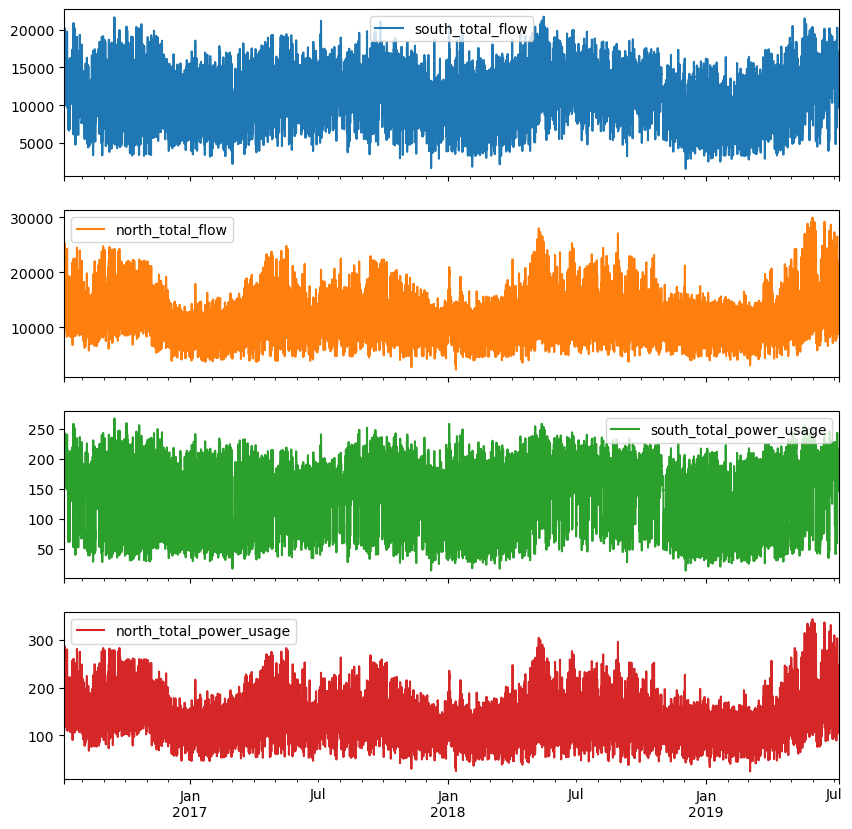

In [53]:
final_data[['south_total_flow', 'north_total_flow', 'south_total_power_usage', 'north_total_power_usage']].plot(figsize=(10,10), subplots=True)

In [60]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

In [100]:
adfuller_test(final_data['north_total_flow'])

ADF Test Statistic : -5.956669620443059
p-value : 2.085371541532448e-07
#Lags Used : 49
Number of Observations Used : 26253
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [103]:
result = seasonal_decompose(final_data['south_total_flow'], model='additive')

In [107]:
result.seasonal

2016-07-07 01:00:00   -2855.026069
2016-07-07 02:00:00   -2962.130894
2016-07-07 03:00:00   -2416.620581
2016-07-07 04:00:00   -1010.720377
2016-07-07 05:00:00     761.531935
                          ...     
2019-07-07 19:00:00     453.892644
2019-07-07 20:00:00     511.589740
2019-07-07 21:00:00     298.938748
2019-07-07 22:00:00    -244.836089
2019-07-07 23:00:00   -1259.091977
Freq: H, Name: seasonal, Length: 26303, dtype: float64

In [110]:
result = STL(final_data['south_total_flow']).fit()

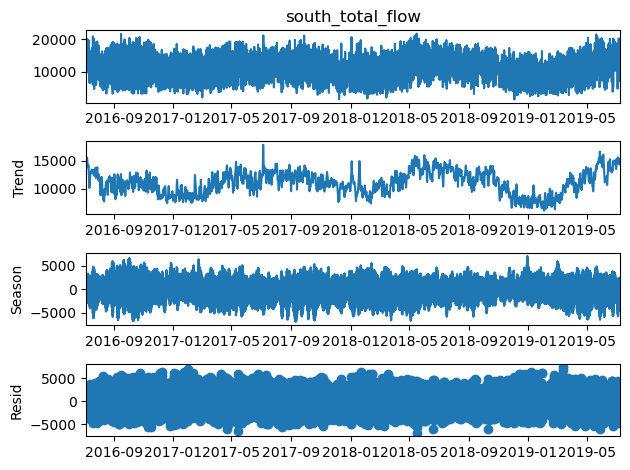

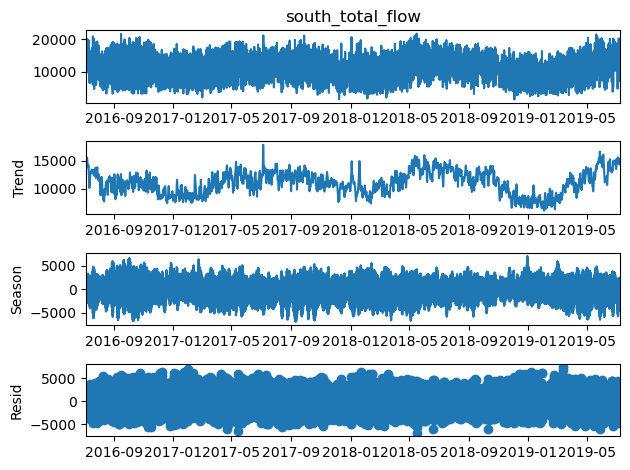

In [111]:
result.plot()